# Mars 2020 SHERLOC Data Processing Pipeline (for data in PDS archive) manual steps

In [7]:
# Import necessary libraries

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colormaps as mpl_colormaps
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import numpy as np
import os
from pybaselines import Baseline, utils
from scipy import stats
from scipy.optimize import curve_fit, differential_evolution
from tqdm.notebook import tqdm
import skimage.draw
import skimage.transform
import shutil
import datetime
from PIL import Image
import urllib.request

plt.rcParams['figure.facecolor'] = 'white'

Set parameters for data processing below. The RLS file includes the coordinates for scan points in the ACI image and is located in the 'SHERLOC Processed Spectroscopy data collection' of the PDS Geosciences Node organized by sol similar to the following, corresponding to sol 861: https://pds-geosciences.wustl.edu/m2020/urn-nasa-pds-mars2020_sherloc/data_processed/sol_00861/.

In [2]:
### PARAMETERS

target = 'Dragons_Egg_Lake'
sol = 861
scan_name = 'detail_1'

output_dir = target

rls_filename = 'ss__0861_0743401635_545rls__0420000srlc11374_104___j02.csv'
aci_filename = 'SC3_0861_0743401530_113ECM_N0420000SRLC11374_0000LMJ01.PNG'

# Filter the min_ID entries in a single scan after visual inspection

This step requires a manual inspection of Gaussian fits for each scan point produced by SHERLOC_DPP_PDS_KHW.ipynb. The peak_ids_to_reject correspond to peak_id in the csv file stored at multifits_path indicated in the code below. Once peak_ids_to_reject have been defined, this code labels those peaks as 'reject' in a new file named like filtered_filename and also in the SHERLOC_multifits_ID_master.csv (which is a database of preliminary mineral identifications). 

In [3]:
# Read the multifits data
multifits_path = f"{output_dir}/{sol}_{target}_{scan_name}_multifits_ID.csv"
multifits = pd.read_csv(multifits_path)

# Define a function to reclassify certain peak_ID values and export the result
def reject_and_export(peak_ids, export_filename):
    # Copy the DataFrame to avoid modifying the original
    multifits_copy = multifits.copy()
    
    # Reclassify 'min_ID' for the specified 'peak_ID' values
    multifits_copy.loc[multifits_copy['peak_ID'].isin(peak_ids), 'min_ID'] = 'reject'
    
    # Export the updated DataFrame to a new CSV file
    multifits_copy.to_csv(export_filename, index=False)

# Use the function to reclassify certain 'peak_ID' values and export the result
peak_ids_to_reject = [1, 2, 4, 6, 11, 20, 22, 29, 34, 36, 39, 42, 48, 61, 97]  # Replace with your actual values
filtered_filename = f"{output_dir}/{sol}_{target}_{scan_name}_multifits_ID_filtered.csv"
reject_and_export(peak_ids_to_reject, filtered_filename)

# Read the master data
master_path = "SHERLOC_multifits_ID_master.csv"
master = pd.read_csv(master_path)

# Define a function to reclassify min_ID in the master DataFrame and update the original file
def reject_and_update_master(peak_ids, sol, target, scan):
    # Construct master_IDs to reject
    master_ids_to_reject = [f"{sol}_{target}_{scan}_f{pid}" for pid in peak_ids]

    # Reclassify 'min_ID' for the specified 'master_ID' values
    master.loc[master['master_ID'].isin(master_ids_to_reject), 'min_ID'] = 'reject'
    
    # Print the changed rows for verification
    changed_rows = master[master['master_ID'].isin(master_ids_to_reject)]
    print(changed_rows)
    
    # Write the updated DataFrame back to the original CSV file
    master.to_csv(master_path, index=False)

# Use the function to reclassify certain 'master_ID' values and update the original file
reject_and_update_master(peak_ids_to_reject, sol, target, scan_name)

     sol            target      scan  point         mean     amplitude  \
0    861  Dragons_Egg_Lake  detail_1      0   700.000000   3015.460321   
1    861  Dragons_Egg_Lake  detail_1      0   988.330458    558.533797   
3    861  Dragons_Egg_Lake  detail_1      0  1066.106632    306.982675   
5    861  Dragons_Egg_Lake  detail_1      1   700.000000    464.060148   
10   861  Dragons_Egg_Lake  detail_1      2  1161.579510    536.309735   
19   861  Dragons_Egg_Lake  detail_1      4  1120.053814   2814.815153   
21   861  Dragons_Egg_Lake  detail_1      5   700.000000    433.560666   
28   861  Dragons_Egg_Lake  detail_1      7   995.226232    399.685852   
33   861  Dragons_Egg_Lake  detail_1      8  1014.467169   2343.836468   
35   861  Dragons_Egg_Lake  detail_1      8  1128.948209    866.267083   
38   861  Dragons_Egg_Lake  detail_1      9  1011.994318    428.310949   
41   861  Dragons_Egg_Lake  detail_1      9  1144.500970    315.645935   
47   861  Dragons_Egg_Lake  detail_1  

# Plotting the spatial distribution of prelimnary mineral detections on the ACI image

This code uses the coordinates for scan points in the RLS file and preliminary mineral detections produced by the previous code to map detections for each min_ID category onto the ACI image, with detections colorized by SNR (as an indicator of relative confidence). Outputs include 300 dpi PNG files for each min_ID category featuring at least one detection, with one file showing the full ACI image and the color bar showing the SNR scale, and another file cropped to the scan area and 3x upscaled to facilitate investigation of any textural associations in the rock target with preliminary mineral detections. 

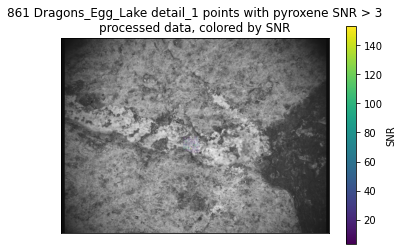

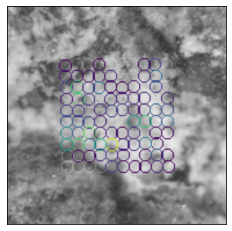

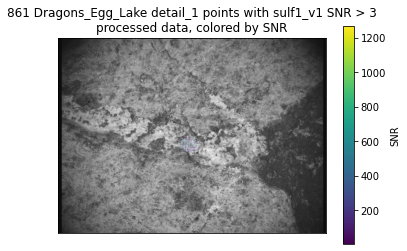

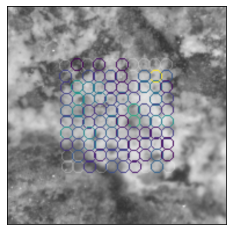

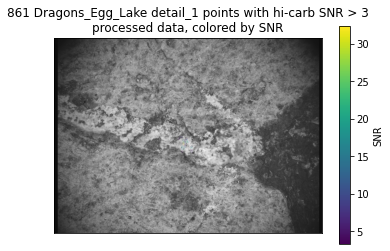

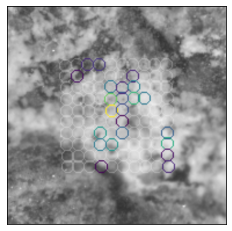

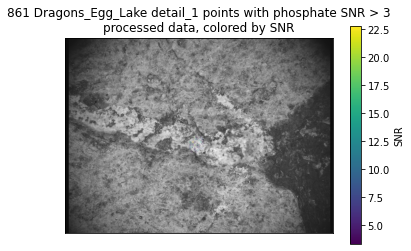

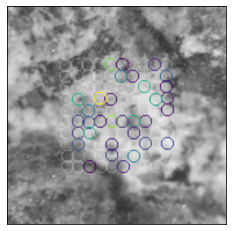

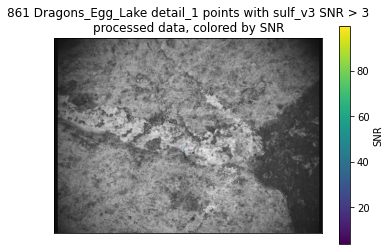

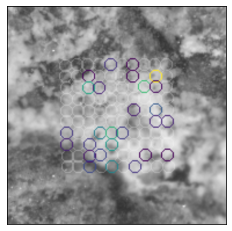

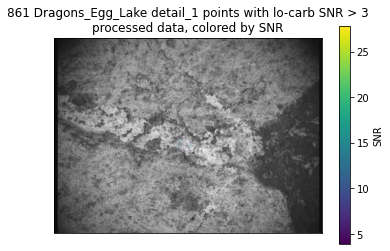

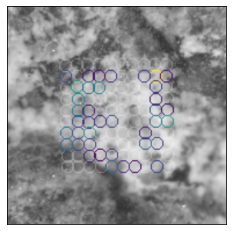

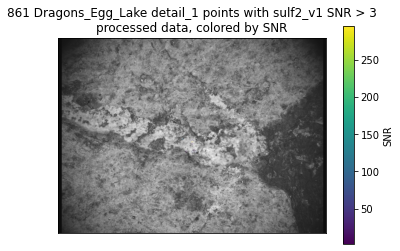

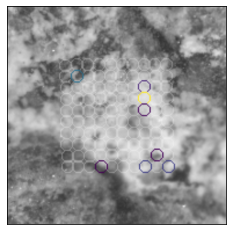

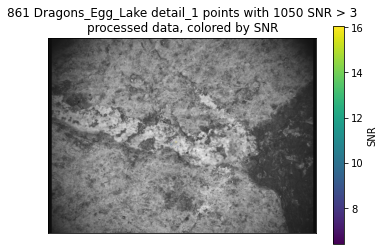

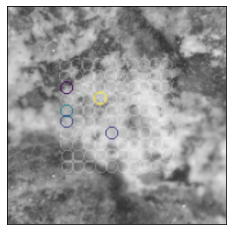

No olivine values found above SNR threshold. Skipping plot generation.


In [4]:
# Construct paths for 'this_spatial' and 'this_aci'
sol_folder = f'sol_{str(sol).zfill(5)}'  # zero-pads sol to 4 digits
this_spatial = rls_filename
this_spatial_path = f"{sol_folder}/{rls_filename}"
this_aci = aci_filename
this_aci_path = f"{sol_folder}/{aci_filename}"

# Load multifits_ID_filtered file
multifits_ID = pd.read_csv(f"{output_dir}/{sol}_{target}_{scan_name}_multifits_ID_filtered.csv")

# Load data using the path
multifit_data = pd.read_csv(this_spatial_path, header=1)

# Load image
img = plt.imread(this_aci_path)

# Check the number of channels in the image and convert to RGBA if necessary
if img.ndim == 2:
    img_rgba = np.zeros((*img.shape, 4))
    img_rgba[..., :3] = img[..., np.newaxis]
    img_rgba[..., 3] = 1
elif img.shape[2] == 3:
    img_rgba = np.zeros((*img.shape[:2], 4))
    img_rgba[..., :3] = img
    img_rgba[..., 3] = 1
else:
    img_rgba = img
    
# Calculate the overall bounding box for all scan points
xmin_all = max(0, multifit_data['samp'].min() - 50)
xmax_all = min(img_rgba.shape[1], multifit_data['samp'].max() + 50)
ymin_all = max(0, multifit_data['line'].min() - 50)
ymax_all = min(img_rgba.shape[0], multifit_data['line'].max() + 50)

# Crop the original image to the scan area (+ additional 50 pixels on each side)
original_cropped = img_rgba[int(ymin_all):int(ymax_all), int(xmin_all):int(xmax_all), :]

# Upscale the cropped original image by 3x
original_upscaled = skimage.transform.resize(original_cropped, 
                                             (original_cropped.shape[0] * 3, original_cropped.shape[1] * 3, original_cropped.shape[2]), 
                                             mode='reflect', anti_aliasing=True)

# Save the cropped, upscaled image
plt.imsave(f"{output_dir}/{sol}_{target}_{scan_name}_cropped_original.png", original_upscaled)

# Iterate over unique mineral IDs
for min_ID in multifits_ID['min_ID'].unique():
    if min_ID in ['reject', 'unidentified']:
        continue
    # Filter data for the current mineral ID with SNR > 3
    filtered_multifits_ID = multifits_ID[(multifits_ID['min_ID'] == min_ID) & (multifits_ID['snr'] > 3)]

    # PLOTTING

    # Filter data for the current mineral ID with SNR > 3
    filtered_multifits_ID = multifits_ID[(multifits_ID['min_ID'] == min_ID) & (multifits_ID['snr'] > 3)]

    # Extract x, y, and point number data for the filtered points
    filtered_points = filtered_multifits_ID['point'].values
    filtered_data = multifit_data[multifit_data['number'].isin(filtered_points)]
    x_values = filtered_data['samp'].values
    y_values = filtered_data['line'].values
    point_values = filtered_data['number'].values
    snr_values = filtered_multifits_ID['snr'].values

    # Create a dictionary mapping point numbers to their corresponding SNR values
    point_to_snr = dict(zip(filtered_multifits_ID['point'], snr_values))

    # Create an empty RGBA image with the same dimensions as the original image
    overlay = np.zeros_like(img_rgba)

    ### START CODE FOR PLOTTING SCAN POINTS THAT DO NOT MEET SNR CRITERION

    # Extract x, y, and point number data for the non-filtered points
    non_filtered_points = np.setdiff1d(multifit_data['number'].values, filtered_points)
    non_filtered_data = multifit_data[multifit_data['number'].isin(non_filtered_points)]
    x_values_non_filtered = non_filtered_data['samp'].values
    y_values_non_filtered = non_filtered_data['line'].values

    # Plot the non-filtered points as white circles with alpha = 0.3
    for x, y in zip(x_values_non_filtered, y_values_non_filtered):
        color_with_alpha = np.array([1, 1, 1, 0.3])  # white color (1, 1, 1) with alpha = 0.3
    
        # Draw a 10x10 pixel open circle
        rr, cc = skimage.draw.circle_perimeter(int(y), int(x), 5)
        valid = (rr >= 0) & (rr < img_rgba.shape[0]) & (cc >= 0) & (cc < img_rgba.shape[1])
        valid_rr, valid_cc = rr[valid], cc[valid]
        for r, c in zip(valid_rr, valid_cc):
            overlay[r, c, :] = color_with_alpha
        
    ### END CODE FOR PLOTTING SCAN POINTS THAT DO NOT MEET SNR CRITERION

    # Check if there are any SNR values before proceeding
    if len(snr_values) > 0:
        # Set up the colormap and normalization for the SNR values
        cmap = mpl_colormaps["viridis"]
        norm = Normalize(vmin=np.min(snr_values), vmax=np.max(snr_values))

        # Plot the circles on the overlay
        for x, y, point in zip(x_values, y_values, point_values):
            snr = point_to_snr[point]  # Get the SNR value for the current point
            color = cmap(norm(snr))
            color_with_alpha = np.array([*color[:3], 1.0])
    
            # Draw a 10x10 pixel open circle
            rr, cc = skimage.draw.circle_perimeter(int(y), int(x), 5)
            valid = (rr >= 0) & (rr < img_rgba.shape[0]) & (cc >= 0) & (cc < img_rgba.shape[1])
            valid_rr, valid_cc = rr[valid], cc[valid]
            for r, c in zip(valid_rr, valid_cc):
                overlay[r, c, :] = color_with_alpha

        # Blend the original image and the overlay using the alpha channel
        combined = overlay[..., :3] * overlay[..., 3:] + img_rgba[..., :3] * (1 - overlay[..., 3:])
        combined_rgba = np.zeros_like(img_rgba)
        combined_rgba[..., :3] = combined
        combined_rgba[..., 3] = 1

        # Generate the dynamic filename
        filename = f"{output_dir}/{sol}_{target}_{scan_name}_{min_ID}_pointloc.png"

        # Save the combined image with the dynamic filename
        plt.imsave(filename, combined_rgba)

        # Plot the combined image without the colorbar
        #fig1, ax1 = plt.subplots(figsize=(img.shape[1] / 100, img.shape[0] / 100), dpi=100)
        #ax1.axis('off')
        #img_display1 = ax1.imshow(combined_rgba)
        #fig1.savefig(f"{output_dir}/{sol}_{target}_{scan_name}_{min_ID}_pointloc_no_colorbar.png", dpi=300, 
                     #bbox_inches='tight', pad_inches=0)

        # Plot the combined image with the colorbar
        fig2, ax2 = plt.subplots()
        img_display2 = ax2.imshow(combined_rgba)
        ax2.set_xticks([])
        ax2.set_yticks([])

        # Add a title to the plot
        ax2.set_title(f"{sol} {target} {scan_name} points with {min_ID} SNR > 3\nprocessed data, colored by SNR")

        # Create a colorbar
        cmap = mpl_colormaps["viridis"]
        norm = matplotlib.colors.Normalize(vmin=np.min(snr_values), vmax=np.max(snr_values))
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array(snr_values)
        cbar = fig2.colorbar(sm, ax=ax2)

        # Set the label for the colorbar
        cbar.set_label("SNR")

        # Display the image with the colorbar
        plt.show()

        # Save the image with the colorbar
        fig2.savefig(f"{output_dir}/{sol}_{target}_{scan_name}_{min_ID}_with_colorbar.png", 
                     dpi=500, bbox_inches='tight')
        
        # Crop the image to the scan area (+ additional 50 pixels on each side)
        cropped = combined_rgba[int(ymin_all):int(ymax_all), int(xmin_all):int(xmax_all), :]

        # Upscale the cropped image by 3x
        upscaled = skimage.transform.resize(cropped, (cropped.shape[0] * 3, cropped.shape[1] * 3, cropped.shape[2]), mode='reflect', anti_aliasing=True)

        # Plot the upscaled image
        fig3, ax3 = plt.subplots()
        im = ax3.imshow(upscaled)

        # Remove the tick marks
        ax3.set_xticks([])
        ax3.set_yticks([])

        # Generate the dynamic filename for the cropped image
        filename_cropped = f"{output_dir}/{sol}_{target}_{scan_name}_{min_ID}_pointloc_zoomed.png"

        # Save the upscaled image with the dynamic filename
        #plt.savefig(filename_cropped, bbox_inches='tight', pad_inches=0, dpi=300)
        plt.imsave(filename_cropped, upscaled)

        # Show plot
        plt.show()
        
        # Close the plots after saving to free up memory:
        #plt.close(fig1)
        plt.close(fig2)
        plt.close(fig3)
    
    else:
        print(f"No {min_ID} values found above SNR threshold. Skipping plot generation.")

# Generating the combined sulfate and carbonate detection plots

This code is similar to the above, but generates combined plots for sulfate (sulf1_v1 and sulf2_v1) and carbonate (hi-carb and lo-carb) $v_1$ detections.

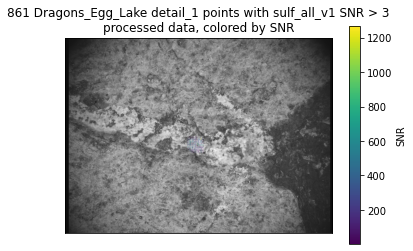

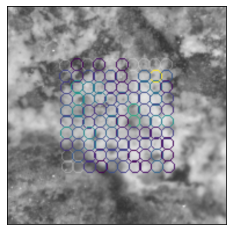

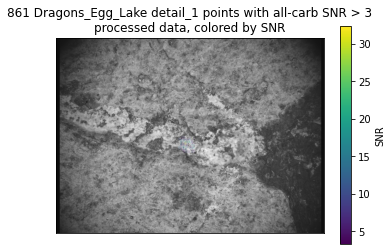

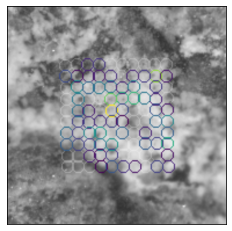

In [5]:
# Construct paths for 'this_spatial' and 'this_aci'
sol_folder = f'sol_{str(sol).zfill(5)}'  # zero-pads sol to 4 digits
this_spatial = rls_filename
this_spatial_path = f"{sol_folder}/{rls_filename}"
this_aci = aci_filename
this_aci_path = f"{sol_folder}/{aci_filename}"

# Load multifits_ID_filtered file
multifits_ID = pd.read_csv(f"{output_dir}/{sol}_{target}_{scan_name}_multifits_ID_filtered.csv")

# Load data using the path
multifit_data = pd.read_csv(this_spatial_path, header=1)

# Load image
img = plt.imread(this_aci_path)

# Check the number of channels in the image and convert to RGBA if necessary
if img.ndim == 2:
    img_rgba = np.zeros((*img.shape, 4))
    img_rgba[..., :3] = img[..., np.newaxis]
    img_rgba[..., 3] = 1
elif img.shape[2] == 3:
    img_rgba = np.zeros((*img.shape[:2], 4))
    img_rgba[..., :3] = img
    img_rgba[..., 3] = 1
else:
    img_rgba = img
    
# Calculate the overall bounding box for all scan points
xmin_all = max(0, multifit_data['samp'].min() - 50)
xmax_all = min(img_rgba.shape[1], multifit_data['samp'].max() + 50)
ymin_all = max(0, multifit_data['line'].min() - 50)
ymax_all = min(img_rgba.shape[0], multifit_data['line'].max() + 50)

# Crop the original image to the scan area (+ additional 50 pixels on each side)
original_cropped = img_rgba[int(ymin_all):int(ymax_all), int(xmin_all):int(xmax_all), :]

# Upscale the cropped original image by 3x
original_upscaled = skimage.transform.resize(original_cropped, 
                                             (original_cropped.shape[0] * 3, original_cropped.shape[1] * 3, original_cropped.shape[2]), 
                                             mode='reflect', anti_aliasing=True)

# Define the dictionary for combinations:
combined_min_IDs = {
    "sulf_all_v1": ["sulf1_v1", "sulf2_v1"],
    "all-carb": ["lo-carb", "hi-carb"]
}

# New loop for combined mineral IDs
for combined_min_ID, min_IDs in combined_min_IDs.items():
    combined_filtered_multifits_ID = pd.concat([
        multifits_ID[(multifits_ID['min_ID'] == min_ID) & (multifits_ID['snr'] > 3)]
        for min_ID in min_IDs
    ])
    
    # Drop duplicates based on the 'point' column
    combined_filtered_multifits_ID = combined_filtered_multifits_ID.drop_duplicates(subset='point')
    
    # Extract x, y, and point number data for the filtered points
    combined_points = combined_filtered_multifits_ID['point'].values
    combined_data = multifit_data[multifit_data['number'].isin(combined_points)]
    x_values = combined_data['samp'].values
    y_values = combined_data['line'].values
    point_values = combined_data['number'].values
    snr_values = combined_filtered_multifits_ID['snr'].values

    # Create a dictionary mapping point numbers to their corresponding SNR values
    point_to_snr = dict(zip(combined_filtered_multifits_ID['point'], snr_values))

    # Create an empty RGBA image with the same dimensions as the original image
    overlay = np.zeros_like(img_rgba)

    # Extract x, y, and point number data for the non-filtered points
    non_combined_points = np.setdiff1d(multifit_data['number'].values, combined_points)
    non_combined_data = multifit_data[multifit_data['number'].isin(non_combined_points)]
    x_values_non_combined = non_combined_data['samp'].values
    y_values_non_combined = non_combined_data['line'].values

    # Plot the non-filtered points as white circles with alpha = 0.3
    for x, y in zip(x_values_non_combined, y_values_non_combined):
        color_with_alpha = np.array([1, 1, 1, 0.3])  # white color (1, 1, 1) with alpha = 0.3
    
        # Draw a 10x10 pixel open circle
        rr, cc = skimage.draw.circle_perimeter(int(y), int(x), 5)
        valid = (rr >= 0) & (rr < img_rgba.shape[0]) & (cc >= 0) & (cc < img_rgba.shape[1])
        valid_rr, valid_cc = rr[valid], cc[valid]
        for r, c in zip(valid_rr, valid_cc):
            overlay[r, c, :] = color_with_alpha

    # Check if there are any SNR values before proceeding
    if len(snr_values) > 0:
        # Set up the colormap and normalization for the SNR values
        cmap = mpl_colormaps["viridis"]
        norm = Normalize(vmin=np.min(snr_values), vmax=np.max(snr_values))

        # Plot the circles on the overlay
        for x, y, point in zip(x_values, y_values, point_values):
            snr = point_to_snr[point]  # Get the SNR value for the current point
            color = cmap(norm(snr))
            color_with_alpha = np.array([*color[:3], 1.0])
    
            # Draw a 10x10 pixel open circle
            rr, cc = skimage.draw.circle_perimeter(int(y), int(x), 5)
            valid = (rr >= 0) & (rr < img_rgba.shape[0]) & (cc >= 0) & (cc < img_rgba.shape[1])
            valid_rr, valid_cc = rr[valid], cc[valid]
            for r, c in zip(valid_rr, valid_cc):
                overlay[r, c, :] = color_with_alpha

        # Blend the original image and the overlay using the alpha channel
        combined = overlay[..., :3] * overlay[..., 3:] + img_rgba[..., :3] * (1 - overlay[..., 3:])
        combined_rgba = np.zeros_like(img_rgba)
        combined_rgba[..., :3] = combined
        combined_rgba[..., 3] = 1

        # Generate the dynamic filename
        filename = f"{output_dir}/{sol}_{target}_{scan_name}_{combined_min_ID}_pointloc.png"

        # Save the combined image with the dynamic filename
        plt.imsave(filename, combined_rgba)

        # Plot the combined image with the colorbar
        fig2, ax2 = plt.subplots()
        img_display2 = ax2.imshow(combined_rgba)
        ax2.set_xticks([])
        ax2.set_yticks([])

        # Add a title to the plot
        ax2.set_title(f"{sol} {target} {scan_name} points with {combined_min_ID} SNR > 3\nprocessed data, colored by SNR")

        # Create a colorbar
        cmap = mpl_colormaps["viridis"]
        norm = matplotlib.colors.Normalize(vmin=np.min(snr_values), vmax=np.max(snr_values))
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array(snr_values)
        cbar = fig2.colorbar(sm, ax=ax2)

        # Set the label for the colorbar
        cbar.set_label("SNR")

        # Display the image with the colorbar
        plt.show()

        # Save the image with the colorbar
        fig2.savefig(f"{output_dir}/{sol}_{target}_{scan_name}_{combined_min_ID}_with_colorbar.png", 
                     dpi=500, bbox_inches='tight')
        
        # Crop the image to the scan area (+ additional 50 pixels on each side)
        cropped = combined_rgba[int(ymin_all):int(ymax_all), int(xmin_all):int(xmax_all), :]

        # Upscale the cropped image by 3x
        upscaled = skimage.transform.resize(cropped, (cropped.shape[0] * 3, cropped.shape[1] * 3, cropped.shape[2]), mode='reflect', anti_aliasing=True)

        # Plot the upscaled image
        fig3, ax3 = plt.subplots()
        im = ax3.imshow(upscaled)

        # Remove the tick marks
        ax3.set_xticks([])
        ax3.set_yticks([])

        # Generate the dynamic filename for the cropped image
        filename_cropped = f"{output_dir}/{sol}_{target}_{scan_name}_{combined_min_ID}_pointloc_zoomed.png"

        # Save the upscaled image with the dynamic filename
        plt.imsave(filename_cropped, upscaled)

        # Show plot
        plt.show()
        
        # Close the plots after saving to free up memory:
        plt.close(fig2)
        plt.close(fig3)
    
    else:
        print(f"No {combined_min_ID} values found above SNR threshold. Skipping plot generation.")

# Generating the combined grid figure

This code generates a single grid figure showing any detections for each of the min_ID categories.

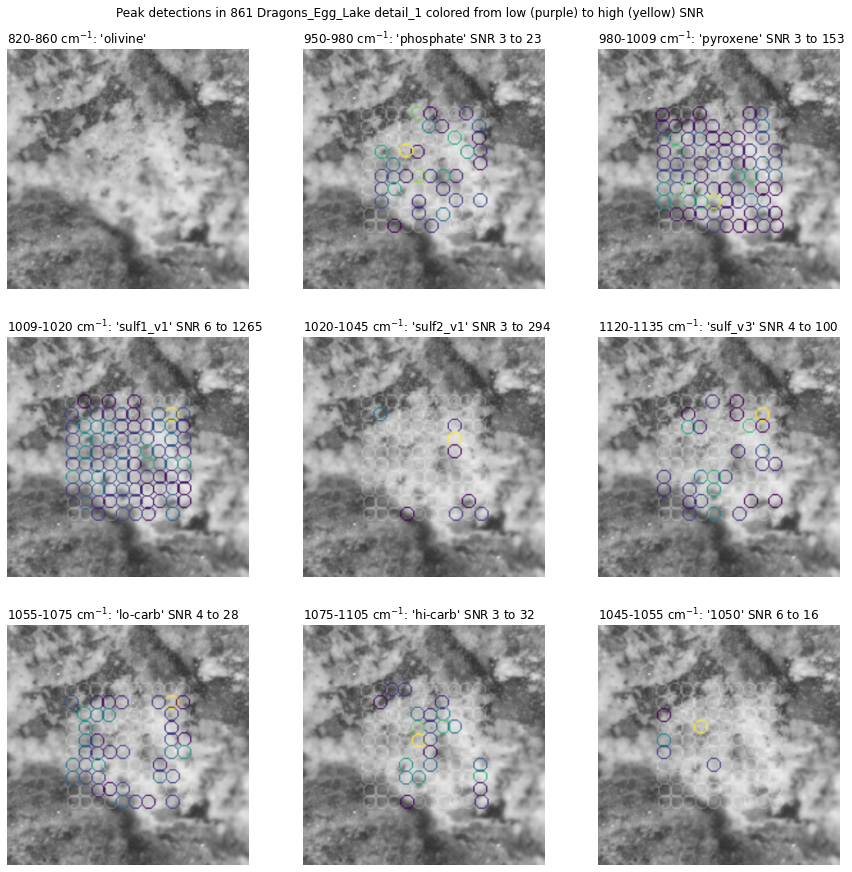

In [6]:
def extract_snr_ranges_from_csv(sol, target, scan_name):
    # Load the multifits_ID_filtered file
    multifits_ID = pd.read_csv(f"{target}/{sol}_{target}_{scan_name}_multifits_ID_filtered.csv")
    
    # Dictionary to hold min and max SNR values for each mineral ID
    snr_ranges = {}

    # Iterate over unique mineral IDs
    for min_ID in multifits_ID['min_ID'].unique():
        if min_ID in ['reject', 'unidentified']:
            continue

        # Filter data for the current mineral ID with SNR > 3
        filtered_multifits_ID = multifits_ID[(multifits_ID['min_ID'] == min_ID) & (multifits_ID['snr'] > 3)]
        snr_values = filtered_multifits_ID['snr'].values
        
        # Check if snr_values is not empty
        if len(snr_values) > 0:
            # Store min and max SNR values in the dictionary
            snr_ranges[min_ID] = (np.min(snr_values), np.max(snr_values))
        else:
            snr_ranges[min_ID] = (None, None)  # Use None values if no SNR data is available

    return snr_ranges

def create_combined_grid_based_on_min_ID(sol, target, scan_name, snr_ranges):
    # Dictionary to map min_ID to spectral range
    mineral_to_range = {
        "olivine": "820-860 cm$^{-1}$",
        "phosphate": "950-980 cm$^{-1}$",
        "pyroxene": "980-1009 cm$^{-1}$",
        "sulf1_v1": "1009-1020 cm$^{-1}$",
        "sulf2_v1": "1020-1045 cm$^{-1}$",
        "sulf_v3": "1120-1135 cm$^{-1}$",
        "lo-carb": "1055-1075 cm$^{-1}$",
        "hi-carb": "1075-1105 cm$^{-1}$",
        "1050": "1045-1055 cm$^{-1}$"
    }
    
    # Create a list of the desired minerals
    minerals = ["olivine", "phosphate", "pyroxene", "sulf1_v1", "sulf2_v1", "sulf_v3", "lo-carb", "hi-carb", "1050"]

    # Create a 3x3 grid to combine the images
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    
    for ax, min_ID in zip(axs.ravel(), minerals):
        # Set the default path to the original image
        img_path = f"{target}/{sol}_{target}_{scan_name}_cropped_original.png"
        
        # Check if the specific mineral image exists, if so update the path
        if os.path.exists(f"{target}/{sol}_{target}_{scan_name}_{min_ID}_pointloc_zoomed.png"):
            img_path = f"{target}/{sol}_{target}_{scan_name}_{min_ID}_pointloc_zoomed.png"
        
        # Load the image
        img = plt.imread(img_path)
        
        # Display the image on the grid
        ax.imshow(img)
        
        # Add the desired label to the bottom-left of the image
        snr_min, snr_max = snr_ranges.get(min_ID, (None, None))
        if snr_min is None or snr_max is None:
            label = f"{mineral_to_range[min_ID]}: '{min_ID}'"
        else:
            label = f"{mineral_to_range[min_ID]}: '{min_ID}' SNR {snr_min:.0f} to {snr_max:.0f}"
        ax.set_title(label, color='black', fontsize=12, ha='left', position=(0,1))

        
        ax.axis('off')

    # Add a title to the combined grid
    fig.suptitle(f"Peak detections in {sol} {target} {scan_name} colored from low (purple) to high (yellow) SNR", fontsize=12, y=0.92)
    
    # Save the combined image
    combined_img_path = f"{target}/{sol}_{target}_{scan_name}_combined_grid.png"
    plt.savefig(combined_img_path, bbox_inches='tight', dpi=300)
    plt.show()

# Extract SNR ranges
snr_ranges = extract_snr_ranges_from_csv(sol, target, scan_name)

# Create the combined grid
create_combined_grid_based_on_min_ID(sol, target, scan_name, snr_ranges)